In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.4 MB 3.9 MB/s 
     |████████████████████████████████| 190 kB 8.6 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7190, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 7190 (delta 52), reused 155 (delta 41), pack-reused 6995
Receiving objects: 100% (7190/7190), 13.43 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (5245/5245), done.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-31 02:35:21--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  5.67MB/s    in 42s     

2022-05-31 02:36:04 (7.43 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'road')
palette = [[0, 0, 0], [255, 255, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet101_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 1, 1),
        strides=(1, 2, 2, 2),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=4),
    decode_head=dict(
        type='FPNHead',
        in_channels=[256, 256, 256, 256],
        in_index=[0, 1, 2, 3],
        feature_strides=[4, 8, 16, 32],
        channels=128,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))

In [11]:
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (512, 512)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

In [12]:
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'

data = dict(
    samples_per_gpu=2,  #batch size
    workers_per_gpu=2,  
    train=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/train',
        ann_dir='gtFine/train',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations'),
            dict(
                type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
            dict(type='RandomCrop', crop_size=(512, 512), cat_max_ratio=0.75),
            dict(type='RandomFlip', prob=0.5),
            dict(type='PhotoMetricDistortion'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size=(512, 512), pad_val=0, seg_pad_val=255),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_semantic_seg'])
        ]),
    val=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]),
    test=dict(
        type='CityscapesDataset',
        data_root='data/cityscapes/',
        img_dir='leftImg8bit/val',
        ann_dir='gtFine/val',
        pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1024, 1024),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]))

In [13]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.model.decode_head.num_classes = 2

cfg.device='cuda'

cfg.model.decode_head.loss_decode = [dict(type='CrossEntropyLoss', loss_weight = 1.0),
                                     dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),                                    
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]

In [14]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 1.5)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [15]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/road_dataset/ann_01_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_train_road.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/road_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/road_dataset/ann_01_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/train/up_val_road.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/road_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/road_dataset/ann_01_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/road_dataset/mask_dir/val/up.txt'

In [16]:
'''
cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'images/up025'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'
'''

"\ncfg.data.train.type = 'SIADataset'\ncfg.data.train.data_root = '/content/drive/MyDrive/SIA'\ncfg.data.train.img_dir = 'images/up025'\ncfg.data.train.ann_dir = 'labels'\ncfg.data.train.pipeline = cfg.train_pipeline\ncfg.data.train.split = '/content/drive/MyDrive/SIA/splits/road/train_road.txt'\n"

In [17]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/CDFL_class2'

In [ ]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='CrossEntropyLoss', loss_weight=1.0),
            dict(type='DiceLoss'

### 모델 학습

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-30 07:08:09,876 - mmseg - INFO - Loaded 542 images
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '
2022-05-30 07:08:22,974 - mmseg - INFO - Loaded 66 images
2022-05-30 07:08:22,977 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-30 07:08:23,418 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.1 task/s, elapsed: 442s, ETA:     0s

2022-05-30 07:24:30,613 - mmseg - INFO - per class results:
2022-05-30 07:24:30,615 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.33 | 95.47 |
|    road    | 59.29 | 72.34 |
+------------+-------+-------+
2022-05-30 07:24:30,618 - mmseg - INFO - Summary:
2022-05-30 07:24:30,620 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 91.52 | 74.81 | 83.9 |
+-------+-------+------+
2022-05-30 07:24:30,623 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9152, mIoU: 0.7481, mAcc: 0.8390, IoU.background: 0.9033, IoU.road: 0.5929, Acc.background: 0.9547, Acc.road: 0.7234
2022-05-30 07:25:12,749 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:49:00, time: 4.840, data_time: 4.445, memory: 3323, decode.loss_ce: 0.2726, decode.loss_dice: 0.1701, decode.loss_focal: 0.0407, decode.loss_lovasz: 0.3230, decode.acc_seg: 89.3766, loss: 0.8064
2022-05-30 07:25:52,596 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 427s, ETA:     0s

2022-05-30 07:38:27,671 - mmseg - INFO - per class results:
2022-05-30 07:38:27,676 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.81 | 95.33 |
|    road    | 61.81 | 75.84 |
+------------+-------+-------+
2022-05-30 07:38:27,681 - mmseg - INFO - Summary:
2022-05-30 07:38:27,682 - mmseg - INFO - 
+------+-------+-------+
| aAcc |  mIoU |  mAcc |
+------+-------+-------+
| 92.0 | 76.31 | 85.59 |
+------+-------+-------+
2022-05-30 07:38:27,685 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9200, mIoU: 0.7631, mAcc: 0.8559, IoU.background: 0.9081, IoU.road: 0.6181, Acc.background: 0.9533, Acc.road: 0.7584
2022-05-30 07:39:07,496 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:21:57, time: 4.666, data_time: 4.273, memory: 3323, decode.loss_ce: 0.2274, decode.loss_dice: 0.1313, decode.loss_focal: 0.0342, decode.loss_lovasz: 0.2796, decode.acc_seg: 91.0165, loss: 0.6725
2022-05-30 07:39:49,553 - mmseg - INFO

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 427s, ETA:     0s

2022-05-30 07:52:23,636 - mmseg - INFO - per class results:
2022-05-30 07:52:23,638 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.86 | 94.94 |
|    road    | 62.78 | 78.22 |
+------------+-------+-------+
2022-05-30 07:52:23,641 - mmseg - INFO - Summary:
2022-05-30 07:52:23,642 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.08 | 76.82 | 86.58 |
+-------+-------+-------+
2022-05-30 07:52:23,644 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9208, mIoU: 0.7682, mAcc: 0.8658, IoU.background: 0.9086, IoU.road: 0.6278, Acc.background: 0.9494, Acc.road: 0.7822
2022-05-30 07:53:03,551 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 4:03:30, time: 4.665, data_time: 4.272, memory: 3323, decode.loss_ce: 0.2278, decode.loss_dice: 0.1237, decode.loss_focal: 0.0350, decode.loss_lovasz: 0.2696, decode.acc_seg: 91.1597, loss: 0.6562
2022-05-30 07:53:43,452 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 427s, ETA:     0s

2022-05-30 08:06:19,134 - mmseg - INFO - per class results:
2022-05-30 08:06:19,135 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.95 | 94.87 |
|    road    | 63.27 | 79.04 |
+------------+-------+-------+
2022-05-30 08:06:19,137 - mmseg - INFO - Summary:
2022-05-30 08:06:19,138 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.17 | 77.11 | 86.96 |
+-------+-------+-------+
2022-05-30 08:06:19,141 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9217, mIoU: 0.7711, mAcc: 0.8696, IoU.background: 0.9095, IoU.road: 0.6327, Acc.background: 0.9487, Acc.road: 0.7904
2022-05-30 08:06:59,024 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:47:13, time: 4.669, data_time: 4.275, memory: 3323, decode.loss_ce: 0.1920, decode.loss_dice: 0.1120, decode.loss_focal: 0.0284, decode.loss_lovasz: 0.2523, decode.acc_seg: 92.2709, loss: 0.5846
2022-05-30 08:07:38,722 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 427s, ETA:     0s

2022-05-30 08:20:14,101 - mmseg - INFO - per class results:
2022-05-30 08:20:14,103 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  91.7 | 97.41 |
|    road    | 61.94 | 69.72 |
+------------+-------+-------+
2022-05-30 08:20:14,104 - mmseg - INFO - Summary:
2022-05-30 08:20:14,106 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.69 | 76.82 | 83.57 |
+-------+-------+-------+
2022-05-30 08:20:14,110 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9269, mIoU: 0.7682, mAcc: 0.8357, IoU.background: 0.9170, IoU.road: 0.6194, Acc.background: 0.9741, Acc.road: 0.6972
2022-05-30 08:20:53,872 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:31:49, time: 4.667, data_time: 4.274, memory: 3323, decode.loss_ce: 0.1939, decode.loss_dice: 0.1119, decode.loss_focal: 0.0288, decode.loss_lovasz: 0.2503, decode.acc_seg: 92.0397, loss: 0.5848
2022-05-30 08:21:33,807 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 427s, ETA:     0s

2022-05-30 08:34:11,019 - mmseg - INFO - per class results:
2022-05-30 08:34:11,021 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.73 | 96.52 |
|    road    | 63.84 | 74.64 |
+------------+-------+-------+
2022-05-30 08:34:11,023 - mmseg - INFO - Summary:
2022-05-30 08:34:11,024 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.78 | 77.79 | 85.58 |
+-------+-------+-------+
2022-05-30 08:34:11,027 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9278, mIoU: 0.7779, mAcc: 0.8558, IoU.background: 0.9173, IoU.road: 0.6384, Acc.background: 0.9652, Acc.road: 0.7464
2022-05-30 08:34:50,865 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:17:00, time: 4.666, data_time: 4.273, memory: 3323, decode.loss_ce: 0.1777, decode.loss_dice: 0.1057, decode.loss_focal: 0.0267, decode.loss_lovasz: 0.2382, decode.acc_seg: 92.8136, loss: 0.5484
2022-05-30 08:35:30,633 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 427s, ETA:     0s

2022-05-30 08:48:04,023 - mmseg - INFO - per class results:
2022-05-30 08:48:04,025 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.86 | 96.35 |
|    road    | 64.77 | 76.27 |
+------------+-------+-------+
2022-05-30 08:48:04,029 - mmseg - INFO - Summary:
2022-05-30 08:48:04,031 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.92 | 78.32 | 86.31 |
+-------+-------+-------+
2022-05-30 08:48:04,034 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9292, mIoU: 0.7832, mAcc: 0.8631, IoU.background: 0.9186, IoU.road: 0.6477, Acc.background: 0.9635, Acc.road: 0.7627
2022-05-30 08:48:46,074 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 3:02:22, time: 4.693, data_time: 4.299, memory: 3323, decode.loss_ce: 0.1903, decode.loss_dice: 0.1196, decode.loss_focal: 0.0283, decode.loss_lovasz: 0.2564, decode.acc_seg: 92.2716, loss: 0.5945
2022-05-30 08:49:26,043 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 426s, ETA:     0s

2022-05-30 09:01:57,354 - mmseg - INFO - per class results:
2022-05-30 09:01:57,356 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.92 | 96.75 |
|    road    | 64.32 | 74.47 |
+------------+-------+-------+
2022-05-30 09:01:57,358 - mmseg - INFO - Summary:
2022-05-30 09:01:57,361 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.95 | 78.12 | 85.61 |
+-------+-------+-------+
2022-05-30 09:01:57,363 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9295, mIoU: 0.7812, mAcc: 0.8561, IoU.background: 0.9192, IoU.road: 0.6432, Acc.background: 0.9675, Acc.road: 0.7447
2022-05-30 09:02:37,116 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:47:48, time: 4.661, data_time: 4.269, memory: 3323, decode.loss_ce: 0.1889, decode.loss_dice: 0.1104, decode.loss_focal: 0.0285, decode.loss_lovasz: 0.2425, decode.acc_seg: 92.4017, loss: 0.5704
2022-05-30 09:03:18,992 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 09:15:49,618 - mmseg - INFO - per class results:
2022-05-30 09:15:49,620 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  92.1 | 96.63 |
|    road    | 65.39 |  76.1 |
+------------+-------+-------+
2022-05-30 09:15:49,622 - mmseg - INFO - Summary:
2022-05-30 09:15:49,627 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.13 | 78.75 | 86.36 |
+-------+-------+-------+
2022-05-30 09:15:49,628 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9313, mIoU: 0.7875, mAcc: 0.8636, IoU.background: 0.9210, IoU.road: 0.6539, Acc.background: 0.9663, Acc.road: 0.7610
2022-05-30 09:16:29,296 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:33:25, time: 4.646, data_time: 4.255, memory: 3323, decode.loss_ce: 0.1673, decode.loss_dice: 0.0932, decode.loss_focal: 0.0249, decode.loss_lovasz: 0.2225, decode.acc_seg: 93.1263, loss: 0.5079
2022-05-30 09:17:08,856 - mmseg -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 09:29:41,738 - mmseg - INFO - per class results:
2022-05-30 09:29:41,740 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.05 | 97.04 |
|    road    | 64.41 | 73.67 |
+------------+-------+-------+
2022-05-30 09:29:41,741 - mmseg - INFO - Summary:
2022-05-30 09:29:41,743 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.05 | 78.23 | 85.35 |
+-------+-------+-------+
2022-05-30 09:29:41,746 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9305, mIoU: 0.7823, mAcc: 0.8535, IoU.background: 0.9205, IoU.road: 0.6441, Acc.background: 0.9704, Acc.road: 0.7367
2022-05-30 09:30:21,346 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:19:09, time: 4.648, data_time: 4.258, memory: 3323, decode.loss_ce: 0.1593, decode.loss_dice: 0.1003, decode.loss_focal: 0.0239, decode.loss_lovasz: 0.2175, decode.acc_seg: 93.4575, loss: 0.5009
2022-05-30 09:31:00,921 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 09:43:33,547 - mmseg - INFO - per class results:
2022-05-30 09:43:33,549 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  91.6 | 95.15 |
|    road    | 65.68 | 81.16 |
+------------+-------+-------+
2022-05-30 09:43:33,551 - mmseg - INFO - Summary:
2022-05-30 09:43:33,553 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.76 | 78.64 | 88.16 |
+-------+-------+-------+
2022-05-30 09:43:33,557 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9276, mIoU: 0.7864, mAcc: 0.8816, IoU.background: 0.9160, IoU.road: 0.6568, Acc.background: 0.9515, Acc.road: 0.8116
2022-05-30 09:44:13,437 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 2:04:56, time: 4.651, data_time: 4.258, memory: 3323, decode.loss_ce: 0.1664, decode.loss_dice: 0.1002, decode.loss_focal: 0.0250, decode.loss_lovasz: 0.2114, decode.acc_seg: 93.2154, loss: 0.5030
2022-05-30 09:44:53,229 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 09:57:26,879 - mmseg - INFO - per class results:
2022-05-30 09:57:26,880 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.77 | 95.85 |
|    road    | 65.25 | 78.39 |
+------------+-------+-------+
2022-05-30 09:57:26,883 - mmseg - INFO - Summary:
2022-05-30 09:57:26,888 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 92.87 | 78.51 | 87.12 |
+-------+-------+-------+
2022-05-30 09:57:26,891 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9287, mIoU: 0.7851, mAcc: 0.8712, IoU.background: 0.9177, IoU.road: 0.6525, Acc.background: 0.9585, Acc.road: 0.7839
2022-05-30 09:58:06,779 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:50:48, time: 4.649, data_time: 4.255, memory: 3323, decode.loss_ce: 0.1624, decode.loss_dice: 0.0896, decode.loss_focal: 0.0244, decode.loss_lovasz: 0.2130, decode.acc_seg: 93.3145, loss: 0.4894
2022-05-30 09:58:46,576 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 10:11:18,727 - mmseg - INFO - per class results:
2022-05-30 10:11:18,729 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  92.1 | 96.49 |
|    road    | 65.64 | 76.84 |
+------------+-------+-------+
2022-05-30 10:11:18,732 - mmseg - INFO - Summary:
2022-05-30 10:11:18,734 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.13 | 78.87 | 86.66 |
+-------+-------+-------+
2022-05-30 10:11:18,735 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9313, mIoU: 0.7887, mAcc: 0.8666, IoU.background: 0.9210, IoU.road: 0.6564, Acc.background: 0.9649, Acc.road: 0.7684
2022-05-30 10:12:00,514 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:36:42, time: 4.669, data_time: 4.278, memory: 3323, decode.loss_ce: 0.1474, decode.loss_dice: 0.0998, decode.loss_focal: 0.0222, decode.loss_lovasz: 0.2002, decode.acc_seg: 94.0710, loss: 0.4697
2022-05-30 10:12:40,207 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 10:25:10,235 - mmseg - INFO - per class results:
2022-05-30 10:25:10,237 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.05 | 96.12 |
|    road    | 66.04 | 78.49 |
+------------+-------+-------+
2022-05-30 10:25:10,241 - mmseg - INFO - Summary:
2022-05-30 10:25:10,243 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 93.11 | 79.04 | 87.3 |
+-------+-------+------+
2022-05-30 10:25:10,244 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9311, mIoU: 0.7904, mAcc: 0.8730, IoU.background: 0.9205, IoU.road: 0.6604, Acc.background: 0.9612, Acc.road: 0.7849
2022-05-30 10:25:52,072 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:22:37, time: 4.670, data_time: 4.278, memory: 3323, decode.loss_ce: 0.1540, decode.loss_dice: 0.0866, decode.loss_focal: 0.0234, decode.loss_lovasz: 0.2046, decode.acc_seg: 93.8154, loss: 0.4687
2022-05-30 10:26:31,772 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 10:39:02,040 - mmseg - INFO - per class results:
2022-05-30 10:39:02,043 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.02 | 96.01 |
|    road    |  66.1 | 78.93 |
+------------+-------+-------+
2022-05-30 10:39:02,044 - mmseg - INFO - Summary:
2022-05-30 10:39:02,046 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.09 | 79.06 | 87.47 |
+-------+-------+-------+
2022-05-30 10:39:02,051 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9309, mIoU: 0.7906, mAcc: 0.8747, IoU.background: 0.9202, IoU.road: 0.6610, Acc.background: 0.9601, Acc.road: 0.7893
2022-05-30 10:39:41,741 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:08:34, time: 4.648, data_time: 4.257, memory: 3323, decode.loss_ce: 0.1337, decode.loss_dice: 0.0823, decode.loss_focal: 0.0200, decode.loss_lovasz: 0.1883, decode.acc_seg: 94.6105, loss: 0.4244
2022-05-30 10:40:23,598 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 10:52:54,906 - mmseg - INFO - per class results:
2022-05-30 10:52:54,908 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.17 | 96.34 |
|    road    | 66.23 | 78.02 |
+------------+-------+-------+
2022-05-30 10:52:54,909 - mmseg - INFO - Summary:
2022-05-30 10:52:54,912 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 93.21 | 79.2 | 87.18 |
+-------+------+-------+
2022-05-30 10:52:54,916 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9321, mIoU: 0.7920, mAcc: 0.8718, IoU.background: 0.9217, IoU.road: 0.6623, Acc.background: 0.9634, Acc.road: 0.7802
2022-05-30 10:53:34,616 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:54:32, time: 4.643, data_time: 4.251, memory: 3323, decode.loss_ce: 0.1623, decode.loss_dice: 0.0893, decode.loss_focal: 0.0245, decode.loss_lovasz: 0.2117, decode.acc_seg: 93.3870, loss: 0.4878
2022-05-30 10:54:14,405 - mmseg - INF

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 11:06:48,024 - mmseg - INFO - per class results:
2022-05-30 11:06:48,026 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 91.99 |  95.9 |
|    road    | 66.19 | 79.38 |
+------------+-------+-------+
2022-05-30 11:06:48,028 - mmseg - INFO - Summary:
2022-05-30 11:06:48,030 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.08 | 79.09 | 87.64 |
+-------+-------+-------+
2022-05-30 11:06:48,033 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9308, mIoU: 0.7909, mAcc: 0.8764, IoU.background: 0.9199, IoU.road: 0.6619, Acc.background: 0.9590, Acc.road: 0.7938
2022-05-30 11:07:27,916 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:40:32, time: 4.648, data_time: 4.255, memory: 3323, decode.loss_ce: 0.1347, decode.loss_dice: 0.0848, decode.loss_focal: 0.0203, decode.loss_lovasz: 0.1971, decode.acc_seg: 94.5161, loss: 0.4369
2022-05-30 11:08:07,538 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 11:20:41,024 - mmseg - INFO - per class results:
2022-05-30 11:20:41,028 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.21 | 96.53 |
|    road    | 66.09 | 77.25 |
+------------+-------+-------+
2022-05-30 11:20:41,030 - mmseg - INFO - Summary:
2022-05-30 11:20:41,033 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.23 | 79.15 | 86.89 |
+-------+-------+-------+
2022-05-30 11:20:41,035 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9323, mIoU: 0.7915, mAcc: 0.8689, IoU.background: 0.9221, IoU.road: 0.6609, Acc.background: 0.9653, Acc.road: 0.7725
2022-05-30 11:21:20,718 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:26:33, time: 4.646, data_time: 4.255, memory: 3323, decode.loss_ce: 0.1377, decode.loss_dice: 0.0773, decode.loss_focal: 0.0209, decode.loss_lovasz: 0.1882, decode.acc_seg: 94.4320, loss: 0.4241
2022-05-30 11:22:00,469 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 11:34:34,781 - mmseg - INFO - per class results:
2022-05-30 11:34:34,783 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.14 | 96.42 |
|    road    | 65.98 | 77.45 |
+------------+-------+-------+
2022-05-30 11:34:34,784 - mmseg - INFO - Summary:
2022-05-30 11:34:34,790 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.18 | 79.06 | 86.94 |
+-------+-------+-------+
2022-05-30 11:34:34,791 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9318, mIoU: 0.7906, mAcc: 0.8694, IoU.background: 0.9214, IoU.road: 0.6598, Acc.background: 0.9642, Acc.road: 0.7745
2022-05-30 11:35:14,578 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:12:34, time: 4.647, data_time: 4.255, memory: 3323, decode.loss_ce: 0.1397, decode.loss_dice: 0.0785, decode.loss_focal: 0.0206, decode.loss_lovasz: 0.1958, decode.acc_seg: 94.1666, loss: 0.4346
2022-05-30 11:35:54,347 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 66/66, 0.2 task/s, elapsed: 425s, ETA:     0s

2022-05-30 11:48:25,423 - mmseg - INFO - per class results:
2022-05-30 11:48:25,426 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 92.19 | 96.34 |
|    road    |  66.3 | 78.08 |
+------------+-------+-------+
2022-05-30 11:48:25,427 - mmseg - INFO - Summary:
2022-05-30 11:48:25,431 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 93.23 | 79.25 | 87.21 |
+-------+-------+-------+
2022-05-30 11:48:25,433 - mmseg - INFO - Iter(val) [66]	aAcc: 0.9323, mIoU: 0.7925, mAcc: 0.8721, IoU.background: 0.9219, IoU.road: 0.6630, Acc.background: 0.9634, Acc.road: 0.7808


### 모델 결과 시각화

/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/CDFL_class2/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


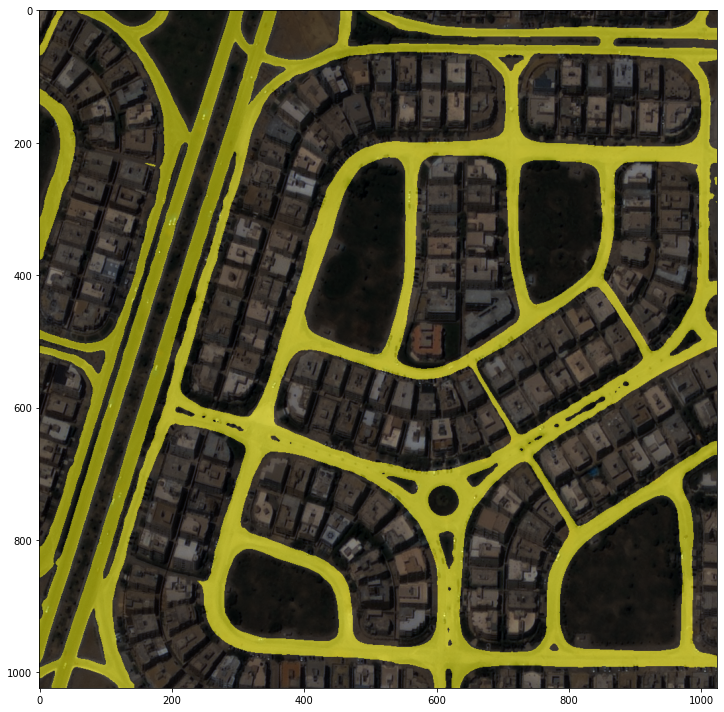

AttributeError: ignored

In [20]:
img_result = ['BLD00002_PS3_K3A_NIA0276.png',
              'BLD00010_PS3_K3A_NIA0276.png',
              'BLD00047_PS3_K3A_NIA0276.png',
              'BLD12071_PS3_K3A_NIA0391.png',
              'BLD11907_PS3_K3A_NIA0391.png',
              'BLD11611_PS3_K3A_NIA0390.png',
              'BLD11474_PS3_K3A_NIA0390.png',
              'BLD10413_PS3_K3A_NIA0388.png',
              'BLD10150_PS3_K3A_NIA0388.png',
              'BLD00836_PS3_K3A_NIA0277.png']

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/CDFL_class2/iter_20000.pth'  #학습된 모델


# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

for ir in range(len(img_result)):
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+img_result[ir])
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img, result, palette)
  model.show_result(img, result, out_file= f'/content/drive/MyDrive/SIA/Morphological/CDFL_Test_Dataset/{ir}')


In [ ]:
import os
file_list = os.listdir('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val')
test_png = []
for i in file_list:
  if '.png' in i:
    test_png.append(i)

for j in test_png:
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+j)
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img, result, palette)

In [23]:
import os
file_list = os.listdir('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val')
test_png = []
for i in file_list:
  if '.png' in i:
    test_png.append(i)

checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/road/CDFL_class2/iter_20000.pth'  #학습된 모델
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용
img2 = np.zeros((1024,1024,3),np.uint8)

for j in test_png:
  img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/road_dataset/img_dir/val/'+j)
  result = inference_segmentor(model_ckpt, img)
  show_result_pyplot(model_ckpt, img2, result, palette)
  model_ckpt.show_result(img2, result, out_file= '/content/drive/MyDrive/SIA/Morphological/CDFL_Test_Dataset/'+j)

Output hidden; open in https://colab.research.google.com to view.